<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Report-Without-Ground-Truth-v1.0" data-toc-modified-id="Report-Without-Ground-Truth-v1.0-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Report Without Ground Truth v1.0</a></span><ul class="toc-item"><li><span><a href="#Input-prameters" data-toc-modified-id="Input-prameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Input prameters</a></span></li></ul></li><li><span><a href="#Variants-Statistics" data-toc-modified-id="Variants-Statistics-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Variants Statistics</a></span></li><li><span><a href="#Snp-statistics" data-toc-modified-id="Snp-statistics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Snp statistics</a></span><ul class="toc-item"><li><span><a href="#Trinucleotide-Heatmap" data-toc-modified-id="Trinucleotide-Heatmap-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Trinucleotide Heatmap</a></span></li></ul></li><li><span><a href="#INDEL-statistics" data-toc-modified-id="INDEL-statistics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>INDEL statistics</a></span><ul class="toc-item"><li><span><a href="#Distribution-of-indel-lengths" data-toc-modified-id="Distribution-of-indel-lengths-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Distribution of indel lengths</a></span></li><li><span><a href="#Insertion-Deletion-Statistics-for-h-mer-indels" data-toc-modified-id="Insertion-Deletion-Statistics-for-h-mer-indels-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Insertion Deletion Statistics for h-mer indels</a></span></li></ul></li></ul></div>

# Report Without Ground Truth v1.0
## Input prameters

In [ ]:
import pandas as pd
from IPython.display import display
from configparser import ConfigParser
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import Markdown

import ugvc.vcfbed.vcftools as vcftools
import h5py

In [1]:
warnings.filterwarnings('ignore')


pd.options.display.float_format = lambda x: '{:,.1e}'.format(x) if x>1e6 else '{:,.1f}'.format(x)
pd.options.display.max_colwidth = 100

configFile='no_gt_report.config'
parser = ConfigParser()
parser.read(configFile)

no_gt_statistics = parser.get('NOGTReport', 'h5_statistics', fallback='no_gt_statistics.h5')
no_gt_statistics_wgs = parser.get('NOGTReport', 'h5_statistics_wgs', fallback='no_gt_statistics_wgs.h5')

is_somatic = parser.getboolean('NOGTReport', 'is_somatic', fallback=False)
filtered_vcf = parser.get('NOGTReport', 'filtered_vcf',fallback='filtered_vcf.vcf.gz')
annotation_intervals_names=parser.get('NOGTReport', 'annotation_intervals_names',fallback='annotation_intervals_names').split(',')
interval_list = parser.get('NOGTReport', 'interval_list')
ref_fasta = parser.get('NOGTReport', 'ref_fasta',fallback='Homo_sapiens_assembly38.fasta')
ref_fasta_dict = parser.get('NOGTReport', 'ref_fasta_dict', fallback='Homo_sapiens_assembly38.dict')
signature_plots_folder = parser.get('NOGTReport', 'signature_plots_folder', fallback='signatures.txt')
cosmic_signatures = parser.get('NOGTReport', 'cosmic_signatures', fallback='cosmic_signatures.json')

prmNames=['run_id','pipeline_version',
          'h5_statistics', 
          'h5_statistics_wgs','annotation_intervals_names','is_somatic','filtered_vcf',
          'interval_list','signature_plots_folder','cosmic_signatures'
         ]

prm={}
for name in prmNames:
    prm[name]=parser.get('NOGTReport', name)

h5outfile = parser.get('NOGTReport', 'h5_output', fallback='no_gt_report.h5')

prmdf = pd.DataFrame.from_dict(prm, orient='index',columns=['value']).reindex(prmNames)
prmdf.to_hdf(h5outfile, key="parameters")
prmdf

NoOptionError: No option 'signature_plots_folder' in section: 'NOGTReport'

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 26
TITLE_SIZE = 36
FIGSIZE = (16, 8)
GRID = True
COLORS = [
    "blue",
    "red",
    "green",
    "magenta",
    "black",
    "brown",
    "orange",
    "salmon",
    "teal",
    "coral",
    "lime",
    "purple",
    "cyan",
    "lavender",
    "turquoise",
    "darkgreen",
    "tan",
    "lightblue",
    "pink",
    "yellow",
    "gold",
]

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=TITLE_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("axes", grid=GRID)  # is grid on
plt.rc("axes", prop_cycle=plt.cycler(color=COLORS))
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=TITLE_SIZE)  # fontsize of the figure title
plt.rc("figure", figsize=FIGSIZE)  # size of the figure


from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")



# Variants Statistics

In [3]:
def metric_table_annotation(h5_path, annotation_name='none'):

    JexlExpression = annotation_name
    metric_table = pd.DataFrame(index=['nEvalVariants','nDeletions','nInsertions','nSNPs','nTi','nTv','tiTvRatio',
                                       'SNP_to_indel_ratio','indel_novelty_rate','insertion_to_deletion_ratio',
                                       'nHets','nHomVar','nMultiSNPs','nMultiIndels','nBiallelicSNPs','nBiallelicIndels'],
                                columns=['novel','known','all'])
    # CompOverlap
    CompOverlap = pd.read_hdf(h5_path,'eval_CompOverlap')
    CompOverlap[['nEvalVariants']] = CompOverlap[['nEvalVariants']].apply(lambda x : pd.to_numeric(x,errors='coerce'))
    metric_table.loc['nEvalVariants','known']=int(CompOverlap.loc[(CompOverlap['JexlExpression']==JexlExpression) & (CompOverlap['Novelty']=='known'),'nEvalVariants'].values[0])
    metric_table.loc['nEvalVariants','novel']=int(CompOverlap.loc[(CompOverlap['JexlExpression']==JexlExpression) & (CompOverlap['Novelty']=='novel'),'nEvalVariants'].values[0])
    metric_table.loc['nEvalVariants','all']=int(CompOverlap.loc[(CompOverlap['JexlExpression']==JexlExpression) & (CompOverlap['Novelty']=='all'),'nEvalVariants'].values[0])
    # CountVariants
    CountVariants = pd.read_hdf(h5_path,'eval_CountVariants')
    CountVariants[["nDeletions","nInsertions","nSNPs","nHets","nHomVar"]] = CountVariants[["nDeletions","nInsertions","nSNPs","nHets","nHomVar"]
                                                                       ].apply(lambda x : pd.to_numeric(x,errors='coerce'))
    metric_table.loc['nDeletions','known']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='known'),'nDeletions'].values[0])
    metric_table.loc['nDeletions','novel']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='novel'),'nDeletions'].values[0])
    metric_table.loc['nDeletions','all']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='all'),'nDeletions'].values[0])
    metric_table.loc['nInsertions','known']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='known'),'nInsertions'].values[0])
    metric_table.loc['nInsertions','novel']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='novel'),'nInsertions'].values[0])
    metric_table.loc['nInsertions','all']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='all'),'nInsertions'].values[0])
    metric_table.loc['nSNPs','known']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='known'),'nSNPs'].values[0])
    metric_table.loc['nSNPs','novel']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='novel'),'nSNPs'].values[0])
    metric_table.loc['nSNPs','all']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='all'),'nSNPs'].values[0])
    metric_table.loc['nHets','known']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='known'),'nHets'].values[0])
    metric_table.loc['nHets','novel']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='novel'),'nHets'].values[0])
    metric_table.loc['nHets','all']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='all'),'nHets'].values[0])
    metric_table.loc['nHomVar','known']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='known'),'nHomVar'].values[0])
    metric_table.loc['nHomVar','novel']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='novel'),'nHomVar'].values[0])
    metric_table.loc['nHomVar','all']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='all'),'nHomVar'].values[0])
    
    # MultiallelicSummary
    MultiallelicSummary = pd.read_hdf(h5_path,'eval_MultiallelicSummary')
    MultiallelicSummary[["nMultiSNPs","nMultiIndels","nSNPs","nIndels"]] = MultiallelicSummary[["nMultiSNPs","nMultiIndels","nSNPs","nIndels"]
                                                                       ].apply(lambda x : pd.to_numeric(x,errors='coerce'))
    metric_table.loc['nMultiSNPs','known']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='known'),'nMultiSNPs'].values[0])
    metric_table.loc['nMultiSNPs','novel']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='novel'),'nMultiSNPs'].values[0])
    metric_table.loc['nMultiSNPs','all']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='all'),'nMultiSNPs'].values[0])
    metric_table.loc['nMultiIndels','known']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='known'),'nMultiIndels'].values[0])
    metric_table.loc['nMultiIndels','novel']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='novel'),'nMultiIndels'].values[0])
    metric_table.loc['nMultiIndels','all']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='all'),'nMultiIndels'].values[0])
    metric_table.loc['nBiallelicSNPs','known']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='known'),'nSNPs'].values[0])- \
        int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='known'),'nMultiSNPs'].values[0])
    metric_table.loc['nBiallelicSNPs','novel']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='novel'),'nSNPs'].values[0])- \
        int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='novel'),'nMultiSNPs'].values[0])
    metric_table.loc['nBiallelicSNPs','all']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='all'),'nSNPs'].values[0]) - \
        int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='all'),'nMultiSNPs'].values[0])
    metric_table.loc['nBiallelicIndels','known']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='known'),'nIndels'].values[0]) - \
        int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='known'),'nMultiIndels'].values[0])
    metric_table.loc['nBiallelicIndels','novel']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='novel'),'nIndels'].values[0]) - \
        int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='novel'),'nMultiIndels'].values[0])
    metric_table.loc['nBiallelicIndels','all']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='all'),'nIndels'].values[0]) - \
        int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='all'),'nMultiIndels'].values[0])

    # TiTvVariantEvaluator
    TiTvVariantEvaluator = pd.read_hdf(h5_path,'eval_TiTvVariantEvaluator')
    TiTvVariantEvaluator[["nTi","nTv","tiTvRatio"]] = TiTvVariantEvaluator[["nTi","nTv","tiTvRatio"]
                                                                       ].apply(lambda x : pd.to_numeric(x,errors='coerce'))
    metric_table.loc['nTi','known']=int(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='known'),'nTi'].values[0])
    metric_table.loc['nTi','novel']=int(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='novel'),'nTi'].values[0])
    metric_table.loc['nTi','all']=int(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='all'),'nTi'].values[0])
    metric_table.loc['nTv','known']=int(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='known'),'nTv'].values[0])
    metric_table.loc['nTv','novel']=int(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='novel'),'nTv'].values[0])
    metric_table.loc['nTv','all']=int(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='all'),'nTv'].values[0])
    metric_table.loc['tiTvRatio','known']=float(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='known'),'tiTvRatio'].values[0])
    metric_table.loc['tiTvRatio','novel']=float(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='novel'),'tiTvRatio'].values[0])
    metric_table.loc['tiTvRatio','all']=float(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='all'),'tiTvRatio'].values[0])

    IndelSummary = pd.read_hdf(h5_path,'eval_IndelSummary')
    IndelSummary[["SNP_het_to_hom_ratio",
                       "SNP_to_indel_ratio",
                       "indel_het_to_hom_ratio",
                       "indel_novelty_rate",
                       "insertion_to_deletion_ratio"]] = IndelSummary[["SNP_het_to_hom_ratio",
                       "SNP_to_indel_ratio",
                       "indel_het_to_hom_ratio",
                       "indel_novelty_rate",
                       "insertion_to_deletion_ratio"]].apply(lambda x : pd.to_numeric(x,errors='coerce'))
    
    metric_table.loc['SNP_to_indel_ratio','known']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='known'),'SNP_to_indel_ratio'].values[0])
    metric_table.loc['SNP_to_indel_ratio','novel']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='novel'),'SNP_to_indel_ratio'].values[0])
    metric_table.loc['SNP_to_indel_ratio','all']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='all'),'SNP_to_indel_ratio'].values[0])
    metric_table.loc['indel_novelty_rate','known']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='known'),'indel_novelty_rate'].values[0])
    metric_table.loc['indel_novelty_rate','novel']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='novel'),'indel_novelty_rate'].values[0])
    metric_table.loc['indel_novelty_rate','all']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='all'),'indel_novelty_rate'].values[0])
    metric_table.loc['insertion_to_deletion_ratio','known']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='known'),'insertion_to_deletion_ratio'].values[0])
    metric_table.loc['insertion_to_deletion_ratio','novel']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='novel'),'insertion_to_deletion_ratio'].values[0])
    metric_table.loc['insertion_to_deletion_ratio','all']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='all'),'insertion_to_deletion_ratio'].values[0])

    if annotation_name == 'none':
        annotation_name = 'wgs'
    mi = pd.MultiIndex.from_tuples([(annotation_name, itm) for itm in list(metric_table.index)],names=['regions','metrics'])
    metric_table.set_index(mi,inplace=True)
    return metric_table

In [4]:
def metric_table(annotation_names,h5_path):
    frames = []
    for annotation_name in annotation_names:
        cur_result = metric_table_annotation(h5_path, annotation_name)
        frames.append(cur_result)
    result = pd.concat(frames)
    return result, frames

merged_df, frames = metric_table(['none']+annotation_intervals_names,no_gt_statistics)
merged_df.to_hdf(h5outfile, key="variants_statistics")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


NameError: name 'h5outfile' is not defined

In [5]:
annotation_name='none'
JexlExpression = annotation_name
metric_table = pd.DataFrame(index=['nEvalVariants','nDeletions','nInsertions','nSNPs','nTi','nTv','tiTvRatio',
                                   'SNP_to_indel_ratio','indel_novelty_rate','insertion_to_deletion_ratio',
                                   'nHets','nHomVar','nMultiSNPs','nMultiIndels','nBiallelicSNPs','nBiallelicIndels'],
                            columns=['novel','known','all'])
CompOverlap = pd.read_hdf(no_gt_statistics,'eval_CompOverlap')
CompOverlap[['nEvalVariants']] = CompOverlap[['nEvalVariants']].apply(lambda x : pd.to_numeric(x,errors='coerce'))
metric_table.loc['nEvalVariants','known']=int(CompOverlap.loc[(CompOverlap['JexlExpression']==JexlExpression) & (CompOverlap['Novelty']=='known'),'nEvalVariants'].values[0])
metric_table.loc['nEvalVariants','novel']=int(CompOverlap.loc[(CompOverlap['JexlExpression']==JexlExpression) & (CompOverlap['Novelty']=='novel'),'nEvalVariants'].values[0])

In [7]:

def multi_column_df_display(list_dfs, cols=2):
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:1px solid !important;background-color: white'>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)
    cells = [ html_cell.format(content=df.to_html()) for df in list_dfs ]
    cells += ((len(list_dfs)%cols)) * [html_cell.format(content="")] # pad
    rows = [ html_row.format(content="".join(cells[i:i+cols])) for i in range(0,len(cells),cols)]
    display(HTML(html_table.format(content="".join(rows))))


multi_column_df_display(frames)



<ul>
<li><b>nEvalVariants</b>- the number of variants <br></li>
<li><b>nDeletions</b>- the number of variants determined to be deletions <br></li>
<li><b>nInsertions</b>- the number of variants determined to be insertions <br></li>
<li><b>nSNPs</b>- the number of variants determined to be single-nucleotide polymorphisms <br></li>
<li><b>nTi</b>- number of transition variants (A↔G or T↔C) <br></li>
<li><b>nTv</b>- number of transversion variants (A↔T or G↔C) <br></li>
<li><b>SNP_to_indel_ratio</b>- n_SNPs divided by n_indels <br></li>
<li><b>indel_novelty_rate</b>- n_novel_indels divided by n_indels<br></li>
<li><b>insertion_to_deletion_ratio</b>- n_insertions divided by n_deletions<br></li>
<li><b>nHets</b>- the number of heterozygous loci<br></li>   
<li><b>nHomVar</b>- the number of homozygous variant loci<br></li>    
<li><b>nMultiSNPs</b>- number of multiallelic SNPs<br></li>
<li><b>nMultiIndels</b>- number of multiallelic indels<br></li>
<li><b>nBiallelicSNPs</b>- nSNPs minus nMultiSNPs<br></li>
<li><b>nBiallelicIndels</b>- nIndels minus nMultiIndels<br></li>
</ul>





In [ ]:
# Open the HDF5 file in read mode
with h5py.File(no_gt_statistics, 'r') as hdf_file:
    if "/callable_size" in hdf_file:
        display(Markdown("""# Callable interval\n"""))
        display(Markdown(f"Callable interval size: {hdf_file['callable_size'][0]:,}\n"))


In [8]:


if is_somatic:
    display(Markdown("""# Distribution of Allele fractions\n
    """))
    display(Markdown("""Histogram of 100 bins of Allele fraction for the somatic data."""))

# Distribution of Allele fractions

    

Histogram of 100 bins of Allele fraction for the somatic data.

In [9]:
def af_hist_graph(filtered_af_hist, annotation_name='none'):
    nbins = 100
    bin_edges = pd.Series(np.arange(0,1,1/nbins))

    for group in filtered_af_hist.columns:

        plt.plot(bin_edges,filtered_af_hist[group]/np.sum(filtered_af_hist[group])*100, alpha=0.5, label=group, linewidth = '3')
        plt.legend(loc='upper right')
        plt.xlabel("Estimated allele fraction")
        plt.ylabel("% Variants")
        plt.title(f'{annotation_name} Pass filter AF histogram', fontsize=24)
    plt.show()

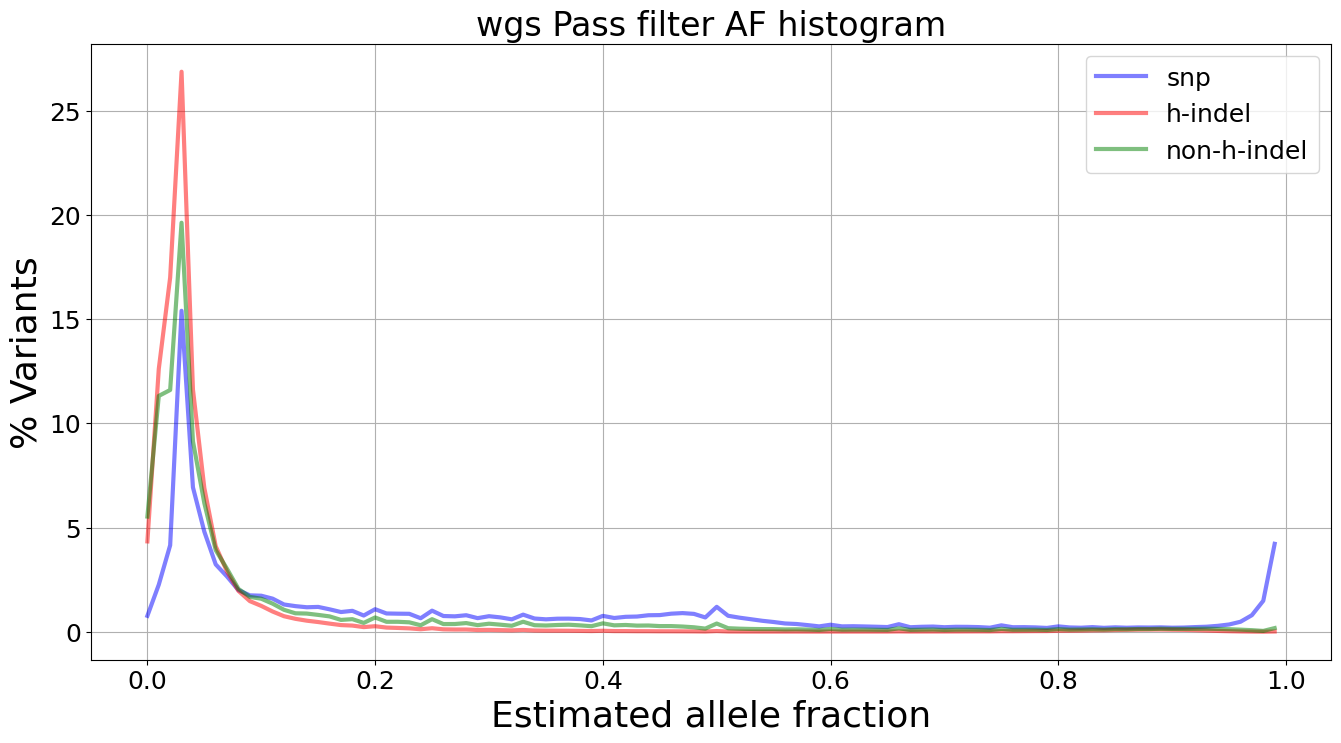

In [10]:
if is_somatic:
    filtered_af_hist = pd.read_hdf(no_gt_statistics_wgs,'af_hist')
    af_hist_graph(filtered_af_hist,'wgs')

In [ ]:
#Read vcf to df
if is_somatic:
    # convert vcf to df
    vcf_df = vcftools.get_vcf_df(filtered_vcf)
    # randomly remove rows if the vcf is too large
    if vcf_df.shape[0]>100000:
        remove_n = vcf_df.shape[0]-100000
        drop_indices = np.random.choice(vcf_df.index, remove_n, replace=False)
        vcf_df = vcf_df.drop(drop_indices)

    if "vaf" in vcf_df.columns:
        vcf_df["af"] = vcf_df["vaf"]

    vcf_df['af'] = vcf_df['af'].apply(lambda x: x[0])

In [11]:
def af_along_genome(vcf_df):
    # for having different color for each chromosome
    vcf_df['ind'] = range(len(vcf_df))
    df_grouped = vcf_df.groupby(('chrom'))
    fig = plt.figure(figsize=(16,10)) # Set the figure size
    ax = fig.add_subplot(111)

    colors = ['#281c65', '#622097', '#a0178a', '#eb2c5d', '#fc6840', '#f8c93c']
    # for locating the x-labels of the different chr
    x_labels = []
    x_labels_pos = []
    for num, (name, group) in enumerate(df_grouped):
        group.plot(kind='scatter', x='ind', y='af',color=colors[num % len(colors)], ax=ax, alpha=0.2)
        x_labels.append(name)
        x_labels_pos.append(group['ind'].iloc[0])
    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels, rotation='vertical')

    # set axis limits
    ax.set_xlim([0, len(vcf_df)])
    ax.set_ylim([0, 1])

    # x axis label
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('Allele Frequency')

    # show the graph
    plt.show()
    

In [12]:
if is_somatic:
    display(Markdown("""# Variant allele frequency along genome positions\n
    """))
    display(Markdown("""Allele frequency values of variants along the genome. Each variant is a point in the graph
    and each color is another chromosome. """))
    af_along_genome(vcf_df)

# Variant allele frequency along genome positions

    

Allele frequency values of variants along the genome. Each variant is a point in the graph
    and each color is another chromosome. 

[W::hts_idx_load3] The index file is older than the data file: /data/deepvariants/report_sig/infer_set1_model_var_coverage.ann.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: /data/deepvariants/report_sig/infer_set1_model_var_coverage.ann.vcf.gz.tbi


KeyboardInterrupt: 

In [ ]:
def af_vs_coverage(vcf_df):
    fig = plt.figure(figsize=(16,10)) # Set the figure size
    ax = fig.add_subplot(111)
    
    ax.scatter(vcf_df['dp'],vcf_df['af'],alpha=0.05)
    
    x_labels = []
    x_labels_pos = []
    
    # set axis limits
    ax.set_ylim([0, 1])

    # x axis label
    ax.set_xlabel('Depth')
    ax.set_ylabel('Allele Frequency')

    # show the graph
    plt.show()

In [ ]:
if is_somatic:
    display(Markdown("""# Variant allele frequency Vs. Depth\n
    """))
    display(Markdown("""Allele frequency values of variants with their corresponding depth. Each variant is a point in the graph
    """))
    af_vs_coverage(vcf_df)

# Snp statistics
Histogram for motif alterations

In [13]:

base_colors = {"A": "b", "C": "r", "T": "y", "G": "g"}
dpi = 150

def plot_motifs0_bars(motifs_0,ax=None, title_prefix = ""):
    if ax is None:
        plt.figure(figsize=(3, 6))
        ax = plt.gca()
    plt.sca(ax)

    x = (motifs_0).sort_index(ascending=False)
    
    bbox_extra_artists = [
        plt.title(f"{title_prefix} {x.sum():.1E} SNPs".replace("E+0", "E"), fontsize=17)
    ]
    (x / motifs_0.sum() * 100).plot.barh(
        color=[base_colors.get(v) for v in x.index.get_level_values("ref")],
        ax=ax,
    )
    plt.yticks(
        ticks=range(6),
        labels=[
            f"{ref}->{alt}" for ref, alt in x.index.values
        ],
    )
    for j, (_, row) in enumerate(x.to_frame().iterrows()):
        bbox_extra_artists += [
            plt.text(
                row["size"] / motifs_0.sum() * 101,
                j + 0.03,
                f"{row['size']:.1E}".replace("E+0", "E"),
            )
        ]
    plt.ylabel("")
    plt.xlabel("Frequency [%]", fontsize=18)
    # plt.xlim(0, ax.get_xlim()[1]+0.1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    return bbox_extra_artists



In [14]:
def snps_statistics_annot(no_gt_statistics, annotation_name='none'):   
    motifs = pd.read_hdf(no_gt_statistics,'snp_motifs')
       
    
    motifs_0 = motifs.reset_index()
    motifs_0 = (
        motifs_0.assign(ref=motifs_0["ref_motif"].str.slice(1, 2))
        .groupby(["ref", "alt_1"])
        .agg({"size": "sum"})
    )["size"]


    fig, ax = plt.subplots(figsize=(6, 6))
    plot_motifs0_bars(motifs_0, ax,title_prefix=annotation_name)


    fig.tight_layout()

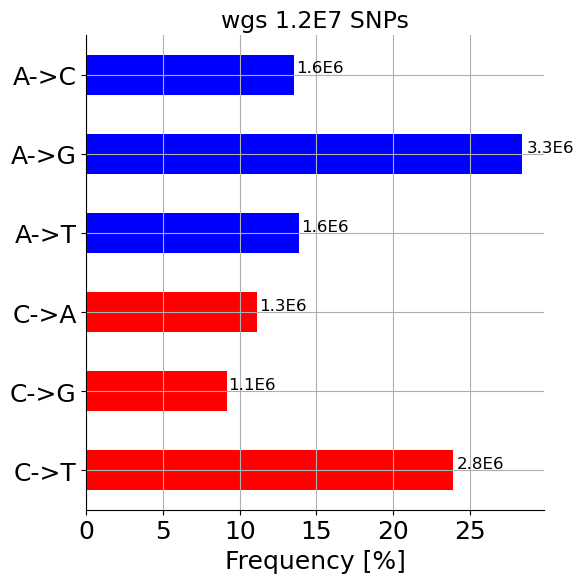

In [15]:
snps_statistics_annot(no_gt_statistics_wgs, 'wgs')


In [16]:
if is_somatic:
    display(Markdown("""# Trinucleotide Histogram \n
    """))
    display(Markdown("""Histogram for motif alterations in trinucleotide context."""))
    
    vcf_prefix = os.path.basename(filtered_vcf).split('.')[0]
    from IPython.display import Image
    from IPython.core.display import HTML
    import json

    f = open(cosmic_signatures)
    cosmic_signatures_file = json.load(f)
    
    def plot_table_and_pngs(key_to_read,png_prefix,key_to_save, profile_key_name):
        sig_activities = pd.read_hdf(no_gt_statistics_wgs, key=key_to_read)
        sig_activities.name='activity'
        sig_activities = sig_activities.astype(float).astype(int)
        sig_activities.sort_values(ascending=False, inplace=True)
        sig_activities = sig_activities.to_frame()
        sig_activities['link']=None
        sig_activities['description']=None
        for sig_name in list(sig_activities.index):
            if sig_name in cosmic_signatures_file:
                sig_activities.loc[sig_name,'description'] = cosmic_signatures_file[sig_name]["descprition"]
                sig_activities.loc[sig_name,'link'] = cosmic_signatures_file[sig_name]["link"]
        # Save the table
        sig_activities.to_hdf(h5outfile, key=key_to_save)
        # Save the profile
        profile = pd.read_hdf(no_gt_statistics_wgs,profile_key_name)
        profile.index = profile.index.astype(str)
        profile.to_hdf(h5outfile, key=profile_key_name)
        # Generate the HTML table
        sig_activities['link'] = sig_activities['link'].apply(lambda x: f'<a href="{x}">{x}</a>')
        html_table = sig_activities.to_html(index=True, classes='my-table', justify='left', escape=False)
        styled_table = html_table.replace("<td>","<td style='text-align: left;'>").replace("<th>","<th style='text-align: center;'>")
        # Display the table
        display(HTML(styled_table))

        
        for sig_name in list(sig_activities.index):
            filename = os.path.join(signature_plots_folder,f'{png_prefix}{sig_name}.png')
            if sig_activities.loc[sig_name,'description'] is not None:
                display(Markdown(f'**{sig_name}**:{sig_activities.loc[sig_name,"description"]}'))
                display(HTML(f"{sig_activities.loc[sig_name,'link']}"))
            display(Image(os.path.join(signature_plots_folder,filename), width=2000, height=900))
            

# Trinucleotide Histogram 

    

Histogram for motif alterations in trinucleotide context.

In [17]:
if is_somatic and os.path.exists(os.path.join(signature_plots_folder,f"SBS_96_plots_{vcf_prefix}.png")):
    display(Markdown("""## SBS sample histogram\n
    """))
    # load activity table
    display(Image(os.path.join(signature_plots_folder,f"SBS_96_plots_{vcf_prefix}.png"), width=2000, height=900))
    display(Markdown("""## Significant SBS Signatures\n
    """))
    plot_table_and_pngs('SBS96_activity','SBS_96_plots_','sbs_activities','SBS96_profile')

## SBS sample histogram

    

FileNotFoundError: No such file or directory: 'SBS_96_plots_infer_set1_model_var_coverage.png'

FileNotFoundError: No such file or directory: 'SBS_96_plots_infer_set1_model_var_coverage.png'

<IPython.core.display.Image object>

## Significant SBS Signatures

    

,activity,link,description
SBS5,1013340,https://cancer.sanger.ac.uk/signatures/sbs/sbs5/,Unknown (clock-like signature)
SBS1,126492,https://cancer.sanger.ac.uk/signatures/sbs/sbs1/,Spontaneous deamination of 5-methylcytosine (clock-like signature)


**SBS5**:Unknown (clock-like signature)

FileNotFoundError: No such file or directory: 'SBS_96_plots_SBS5.png'

FileNotFoundError: No such file or directory: 'SBS_96_plots_SBS5.png'

<IPython.core.display.Image object>

**SBS1**:Spontaneous deamination of 5-methylcytosine (clock-like signature)

FileNotFoundError: No such file or directory: 'SBS_96_plots_SBS1.png'

FileNotFoundError: No such file or directory: 'SBS_96_plots_SBS1.png'

<IPython.core.display.Image object>

In [37]:
if is_somatic and os.path.exists(os.path.join(signature_plots_folder,f"ID_83_plots_{vcf_prefix}.png")):
    display(Markdown("""## ID sample histogram\n
    """))
    # load activity table
    display(Image(os.path.join(signature_plots_folder,f"ID_83_plots_{vcf_prefix}.png"), width=2000, height=900))
    display(Markdown("""## Significant ID Signatures\n
    """))
    plot_table_and_pngs('ID83_activity','ID_83_plots_','id_activities','ID83_profile')

## ID sample histogram

    

FileNotFoundError: No such file or directory: 'ID_83_plots_infer_set1_model_var_coverage.png'

FileNotFoundError: No such file or directory: 'ID_83_plots_infer_set1_model_var_coverage.png'

<IPython.core.display.Image object>

## Significant ID Signatures

    

,activity,link,description
ID12,49283,https://cancer.sanger.ac.uk/signatures/id/id12/,Unknown
ID10,41915,https://cancer.sanger.ac.uk/signatures/id/id10/,Unknown
ID1,31464,https://cancer.sanger.ac.uk/signatures/id/id1/,Slippage during DNA replication of the replicated DNA strand
ID2,26431,https://cancer.sanger.ac.uk/signatures/id/id2/,Slippage during DNA replication of the replicated DNA strand


**ID12**:Unknown

FileNotFoundError: No such file or directory: 'ID_83_plots_ID12.png'

FileNotFoundError: No such file or directory: 'ID_83_plots_ID12.png'

<IPython.core.display.Image object>

**ID10**:Unknown

FileNotFoundError: No such file or directory: 'ID_83_plots_ID10.png'

FileNotFoundError: No such file or directory: 'ID_83_plots_ID10.png'

<IPython.core.display.Image object>

**ID1**:Slippage during DNA replication of the replicated DNA strand

FileNotFoundError: No such file or directory: 'ID_83_plots_ID1.png'

FileNotFoundError: No such file or directory: 'ID_83_plots_ID1.png'

<IPython.core.display.Image object>

**ID2**:Slippage during DNA replication of the replicated DNA strand

FileNotFoundError: No such file or directory: 'ID_83_plots_ID2.png'

FileNotFoundError: No such file or directory: 'ID_83_plots_ID2.png'

<IPython.core.display.Image object>

In [19]:
if is_somatic and os.path.exists(os.path.join(signature_plots_folder,f"DBS_78_plots_{vcf_prefix}.png")):
    display(Markdown("""## DBS sample histogram\n
    """))
    # load activity table
    display(Image(os.path.join(signature_plots_folder,f"DBS_78_plots_{vcf_prefix}.png"), width=2000, height=900))
    display(Markdown("""## Significant DBS Signatures\n
    """))
    plot_table_and_pngs('DBS78_activity','DBS_78_plots_','dbs_activities','DBS78_profile')

## DBS sample histogram

    

FileNotFoundError: No such file or directory: 'DBS_78_plots_infer_set1_model_var_coverage.png'

FileNotFoundError: No such file or directory: 'DBS_78_plots_infer_set1_model_var_coverage.png'

<IPython.core.display.Image object>

## Significant DBS Signatures

    

NameError: name 'plot_table_and_pngs' is not defined

# INDEL statistics

## Distribution of indel lengths

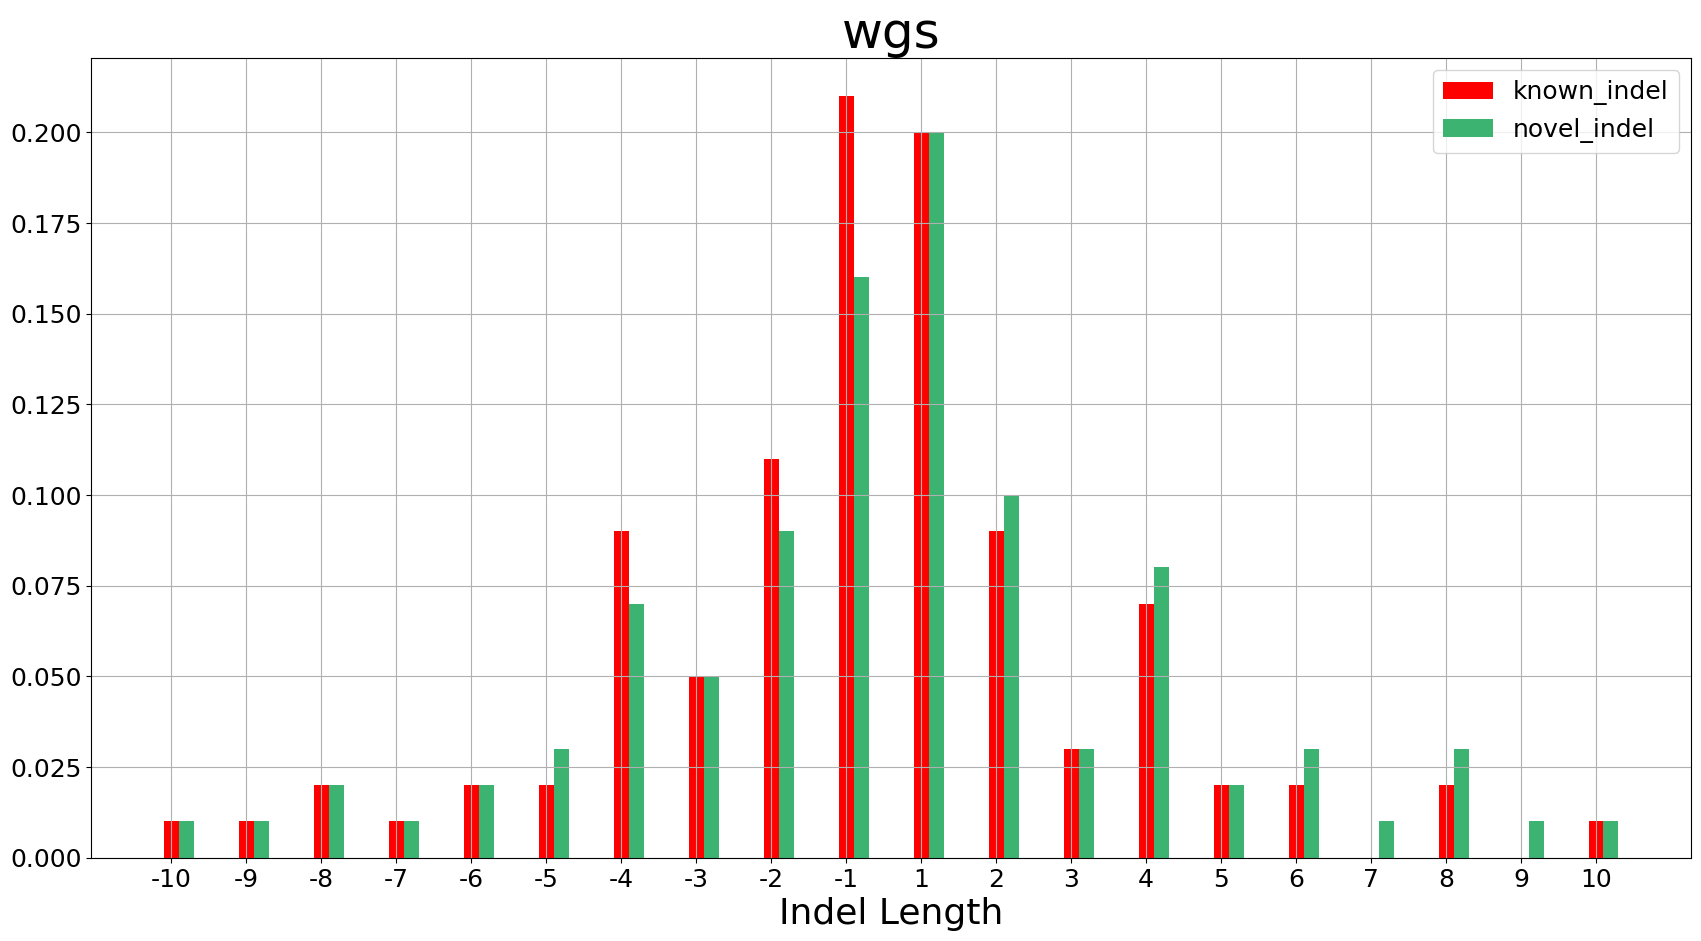

In [18]:
def ins_del_hete_graph_annot(known_indel,novel_indel, title=None):
    X = np.arange(20)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    
    ax.bar(X + 0.00, known_indel, color = 'r', width = 0.20)
    ax.bar(X + 0.20, novel_indel, color = 'mediumseagreen', width = 0.20)

    ax.set_title(title)
    ax.set_xticks(np.arange(0,20))
    ax.set_xticklabels([-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10])
    ax.legend(labels=['known_indel', 'novel_indel'])
    ax.set_xlabel('Indel Length')
    
    

def ins_del_hete_graph(no_gt_statistics):
    
    #for no_gt_statistics,no_gt_statistics,annotation_name in zip(no_gt_statistics_files,no_gt_statistics_files,annotation_intervals_names):
        
    IndelLengthHistogram = pd.read_hdf(no_gt_statistics,'eval_IndelLengthHistogram')
    

    known_indel = IndelLengthHistogram[IndelLengthHistogram['Novelty']=='known']['Freq'].astype(float)
    novel_indel = IndelLengthHistogram[IndelLengthHistogram['Novelty']=='novel']['Freq'].astype(float)

    ins_del_hete_graph_annot(known_indel,
               novel_indel,
               title='wgs')
        
ins_del_hete_graph(no_gt_statistics_wgs)

## Insertion Deletion Statistics for h-mer indels
Number of 1-base insretion deletions in hmer of each length

In [19]:
if not is_somatic:
    display(Markdown("""## Heterozygous
    """))

In [20]:
def ins_del_hete_graph(ins_del, ax, title):
    X = np.arange(12)
    
    ax.bar(X + 0.00, ins_del.iloc[0], color = 'r', width = 0.3)
    ax.bar(X + 0.3, ins_del.iloc[1], color = 'mediumseagreen', width = 0.3)
    ax.bar(X + 0.00, -ins_del.iloc[2], color = 'purple', width = 0.3)
    ax.bar(X + 0.3, -ins_del.iloc[3], color = 'g', width = 0.3)

    ax.set_title(title, fontsize=18)
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(pd.Series(np.arange(1,13)).apply(lambda x: f"hmer {x}"),rotation=45)
    ax.legend(labels=['ins A', 'ins G', 'del A', 'del G'])
    ax.set_yticks(ax.get_yticks())
    
    ax.set_yticklabels([abs(x).astype(int) for x in ax.get_yticks()])
    ax.set_ylabel("Deletion        /       Insertion",

               loc="center")

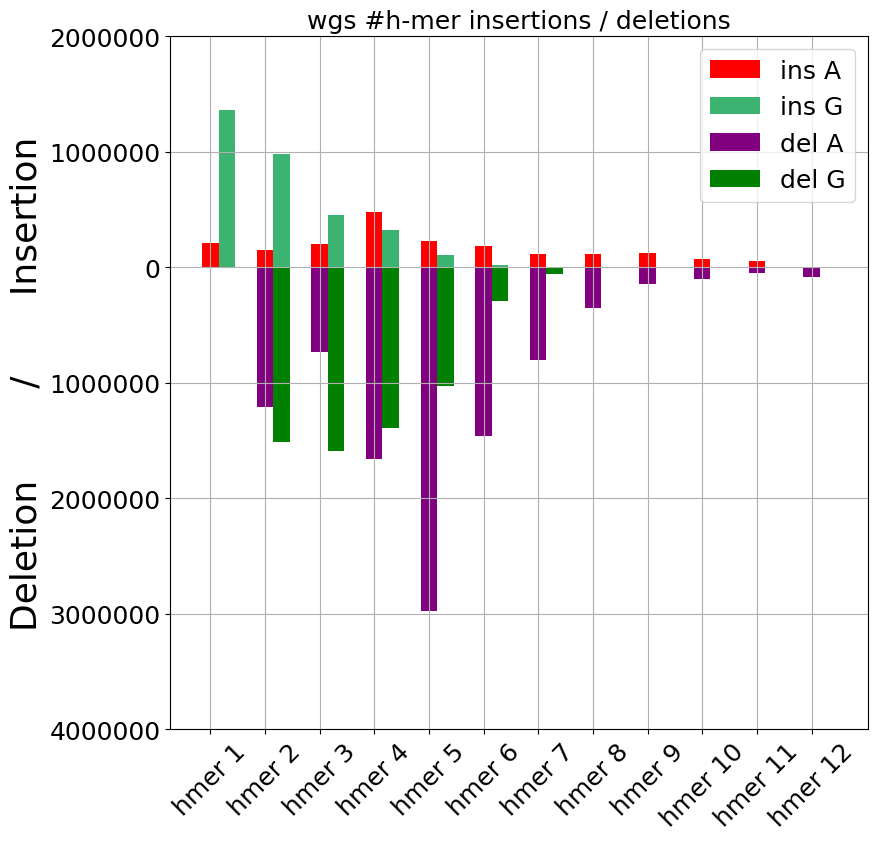

In [21]:
annotation_name = 'wgs'
ins_del_hete = pd.read_hdf(no_gt_statistics_wgs,'ins_del_hete')
ins_del_hete.columns = pd.Series(ins_del_hete.columns).apply(lambda x: f"h-mer {x}")

fig, ax = plt.subplots(figsize=(9, 9))
ins_del_hete_graph(ins_del_hete, ax, f'{annotation_name} #h-mer insertions / deletions')

In [ ]:
if not is_somatic:
    display(Markdown("""## Homozygous
    """))

In [ ]:
if not is_somatic:
    ins_del_homo = pd.read_hdf(no_gt_statistics_wgs,'ins_del_homo')
    ins_del_homo.columns = pd.Series(ins_del_homo.columns).apply(lambda x: f"h-mer {x}")
    fig, ax = plt.subplots(figsize=(9, 9))
    ins_del_hete_graph(ins_del_homo, ax, f'wgs # insertions / deletions')